In [1]:
%env KMP_DUPLICATE_LIB_OK=TRUE 
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from nfmd import NFMD

# Pull out common plotting settings:
from plot_params import get_plot_params
full_params, half_params = get_plot_params()
full_params['lines.linewidth'] = 1
full_params['figure.figsize'] = (7, 3.5)
plt.rcParams.update(full_params)

env: KMP_DUPLICATE_LIB_OK=TRUE


# Set up the signal


In [2]:
# Generate an example signal
fs = 5000
t_max = 1
n = int(fs*t_max)

# Build signal
t = np.linspace(0,t_max,n)
dt = t[1]-t[0]


# Define a time-dependent phase function
f_base = 100
df_1 = 10
tau_1 = 0.5
omega_1 = lambda x: f_base + (df_1)*(1-np.exp(-x/tau_1))
amp_1 = lambda x: 1 + 0.5*np.exp(-x/3)


omega_2 = lambda x: 25-0.5*x
amp_2 = lambda x: 2 - 0.5*np.exp(-x)


# Create data with time-dependent frequency
z_1 = lambda t: amp_1(t)*np.cos(2*np.pi*omega_1(t)*t)
z_2 = lambda t: amp_2(t)*np.sin(2*np.pi*omega_2(t)*t) 
z = z_1(t) 
z += z_2(t)

In [3]:
%%time

# Slice out part of the signal of interest:
t1 = 0.03
t2 = 0.07
t_mid = (t1+t2)/2

# Set a similar slice of the data to deal with:
idcs1 = np.argwhere(t<t2)
idcs2 = np.argwhere(t>=t1)
idcs = np.intersect1d(idcs1, idcs2)

# Do NFMD on the slice:
signal = z[idcs]


###############
# Nonstationary Fourier Mode Decomposition
###############
nfmd = NFMD(signal/np.std(signal),
            num_freqs=2,
            window_size=200,
            max_iters=100,
            target_loss=1e-3)


freqs, A, losses, indices = nfmd.decompose_signal()

# Compute the modes from NFMD:
num_modes = 2
modes = []

for i in range(num_modes):
    # create time vector
    window_t = np.expand_dims(np.arange(len(signal)),-1)
    # extract the A vector - note 0 index used because there
    # is ONE time window being analyzed, and we want data from that window:
    freq = nfmd.freqs[0][i]
    A = nfmd.A[0][i::num_modes]
    Omega = np.concatenate([np.cos(window_t*2*np.pi*freq),
                            np.sin(window_t*2*np.pi*freq)], -1)
    mode = np.dot(Omega, A)
    modes.append(mode)


Wall time: 154 ms


In [4]:
%%time
###############
# STFT
###############

# Define the windowing function an STFT would use:
box = np.array([1 if n<t2 and n>=t1 else 0 for n in t])
box = np.exp(-((t-t_mid)/0.02)**2)

# Compute FFT of boxed window
f_pz = np.fft.fft(box*z)
frqs = np.fft.fftfreq((box*z).shape[0])

Wall time: 2 ms


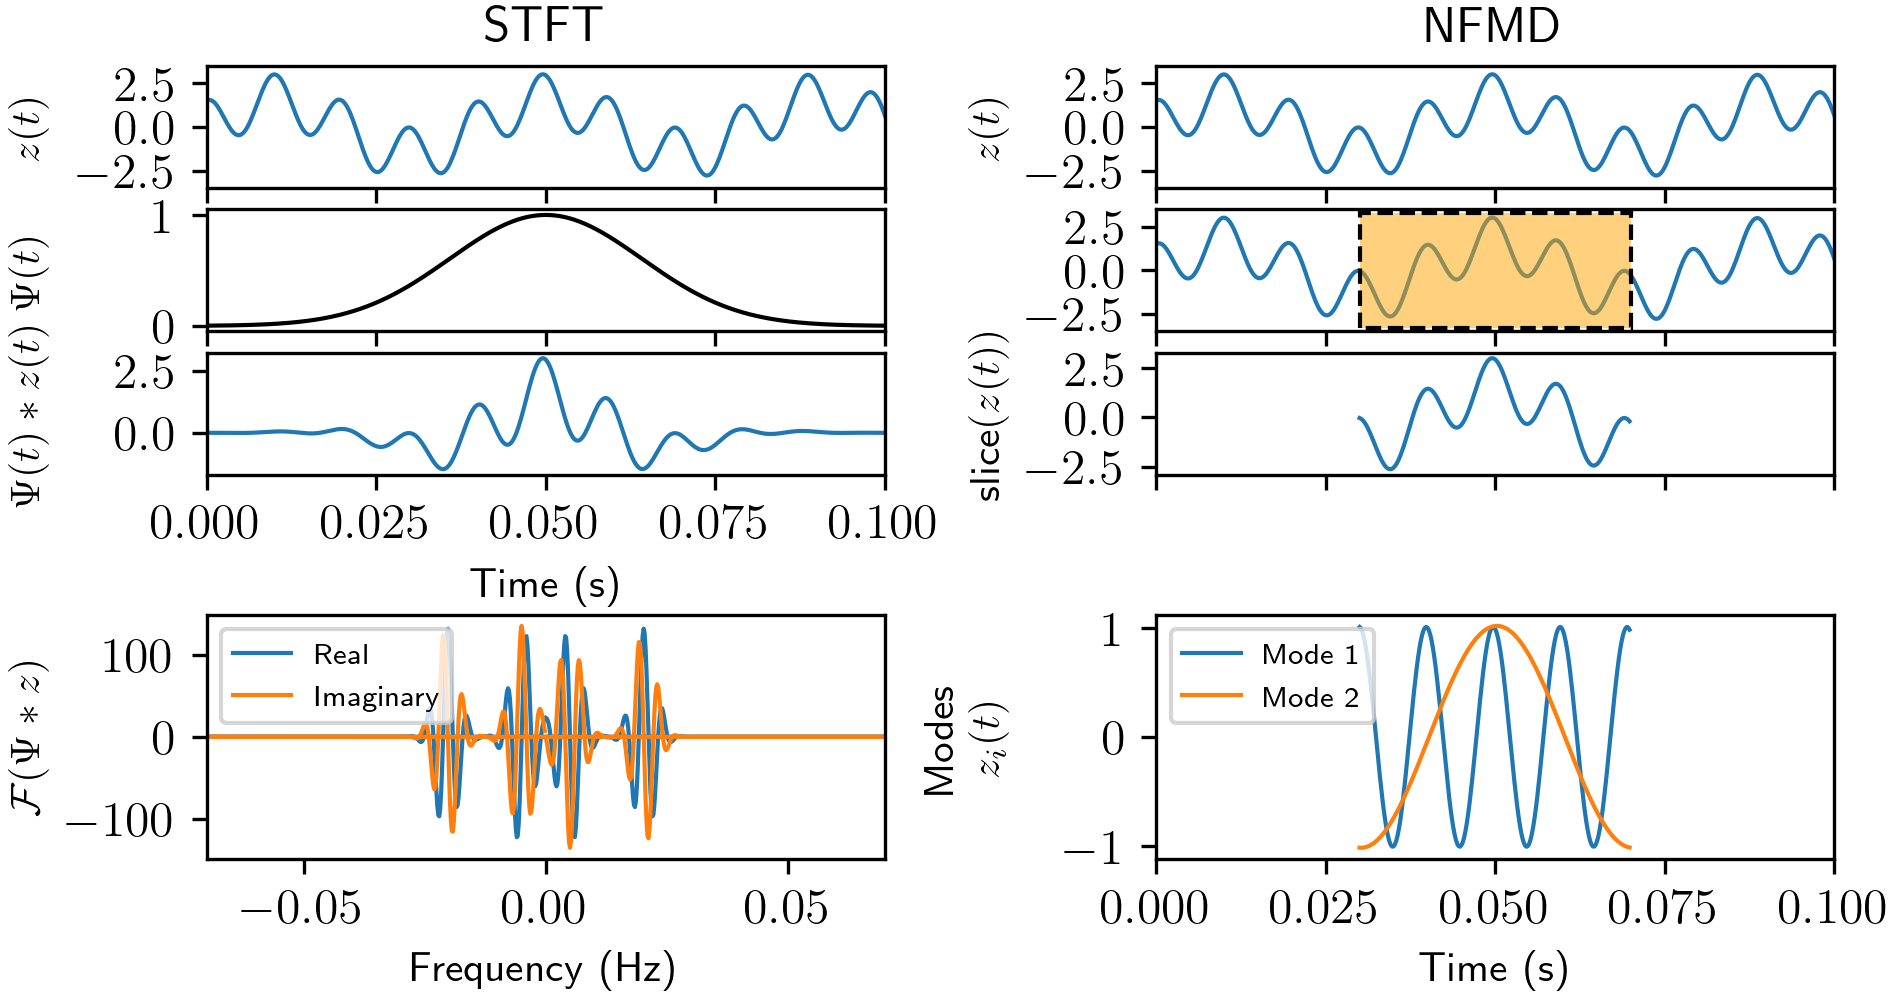

In [19]:
fig = plt.figure()
gs = GridSpec(5,2,height_ratios=[1,1,1,0.8,2])

#########################
## First Column - NFMD ##
#########################
ax1n = plt.subplot(gs[0,1])
ax2n = plt.subplot(gs[1,1], sharex=ax1n)
ax3n = plt.subplot(gs[2,1], sharex=ax1n)
ax4n = plt.subplot(gs[4,1], sharex=ax1n)
axsn = [ax1n,ax2n,ax3n,ax4n]

# Set title for the column
ax1n.set_title("NFMD")

# Plot the signal
ax1n.plot(t, z, zorder=-1)
ax1n.set_ylabel('$z(t)$')

# Plot the selected window over the signal
ax2n.plot(t, z, zorder=-1)

# Add shaded box
ax2n.axvspan(t1,t2,0.03,0.97, facecolor='orange', lw=None, alpha=0.5, zorder=0)  # Orange fill on the box
ax2n.axvspan(t1,t2,0.03,0.97, fill=False, edgecolor='k', linestyle='--', alpha=1, zorder=1)  # Dashed outline on the box
#ax2[0].arrow(0.035, 2.5, 0.02, 0, width=1, head_width=1.5, head_length=0.005, facecolor='k', lw=None, alpha=0.75, zorder=2)  # Arrow


# Plot the product of signal with windowing function
ax3n.plot(t[idcs], z[idcs])
ax3n.set_ylabel("slice$(z(t))$")


# Plot the output of the NFMD for the signal
for mode in modes:
    ax4n.plot(t[idcs], mode)
    
# Format shared x-axis
ax4n.set_ylabel("Modes\n$z_i(t)$")
ax4n.set_xlabel('Time (s)')
ax4n.set_xlim([0,0.1])
ax4n.legend(labels=["Mode 1","Mode 2"], fontsize=7, loc='upper left')

# Hide other axes' labels
plt.setp(ax1n.get_xticklabels(), visible=False)
plt.setp(ax2n.get_xticklabels(), visible=False)
plt.setp(ax3n.get_xticklabels(), visible=False)

###########################
## Second Column -- STFT ##
###########################
ax1g = plt.subplot(gs[0,0])
ax2g = plt.subplot(gs[1,0], sharex=ax1g)
ax3g = plt.subplot(gs[2,0], sharex=ax1g)
ax4g = plt.subplot(gs[4,0])
axsg = [ax1g,ax2g,ax3g,ax4g]

# Set title for the column
ax1g.set_title("STFT")

# Plot the signal
ax1g.plot(t, z)
ax1g.set_ylabel('$z(t)$')

# Plot the windowing function
ax2g.plot(t, box, 'k', lw=1)
ax2g.set_ylabel("$\Psi(t)$")

# Plot the product of signal with windowing function

ax3g.plot(t, box*z)
ax3g.set_ylabel("$\Psi(t)*z(t)$")

# format the shared x-axis
ax3g.set_xlabel('Time (s)')
ax3g.set_xlim([0,0.1])

# Hide other axes' labels
plt.setp(ax1g.get_xticklabels(), visible=False)
plt.setp(ax2g.get_xticklabels(), visible=False)


# Plot FFT of the windowed signal
ax4g.plot(frqs, f_pz.real)
ax4g.plot(frqs, f_pz.imag)

# Format last axes:
ax4g.set_xlim(-0.07,0.07)
ax4g.set_ylabel("$\mathcal{F}(\Psi*z)$")
ax4g.set_xlabel("Frequency (Hz)")
ax4g.legend(labels=["Real","Imaginary"], fontsize=7, loc='upper left')

plt.subplots_adjust(wspace=0.4, hspace=0.15)
#plt.tight_layout()

fig.align_ylabels(axsn)
fig.align_ylabels(axsg)

plt.savefig("shea1.png")